# U-NET
U-Net is a convolutional neural network that was developed for biomedical image segmentation. The network is based on a fully convolutional network whose architecture was modified and extended to work with fewer training images and yield more precise segmentation.

U-Net was first proposed in a research paper published in 2015.

U-net architecture is symmetric and consists of two major parts: * The left part is called the contracting path, constituted by the general convolutional process.

The right part is an expansive path, constituted by transposed 2D convolutional layers.

The architecture of U-NET is

<img src="./figures/u-net-architecture.png" title="UNET" />



The main idea is to supplement a usual contracting network by successive layers, where upsampling operators replace pooling operations. Hence these layers increase the resolution of the output. What’s more, a successive convolutional layer can then learn to assemble a precise output based on this information.

## Key features
- U-Net learns segmentation in an end-to-end setting: You input a raw image and get a segmentation map as the output.

- U-Net is able to precisely localize and distinguish borders: Performs classification on every pixel so that the input and output share the same size.

- U-Net uses very few annotated images: Data augmentation with elastic deformations reduces the number of annotated images required for training.



In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download dataset [Image-Segmentation-with-UNet-PyTorch](https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch)

In [2]:
class Agrument:
    images = "./data/kaggle_3m"
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15
    batch_size = 32
    epochs = 10
    lr = 0.0001
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
args = Agrument()
device = args.device

data_dir = "data/cityscapes_data"
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print('Size of train dataset', len(train_fns))
print('Size of validation dataset',len(val_fns))

Size of train dataset 2975
Size of validation dataset 500


data/cityscapes_data/train/1149.jpg


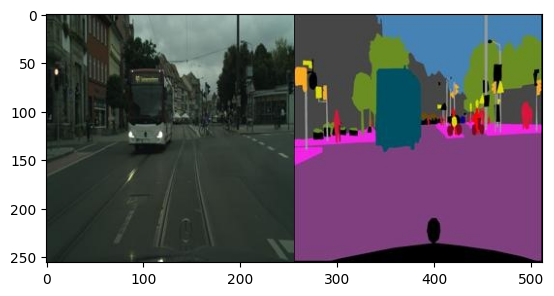

In [3]:
## Checking image
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

## Preprocessing

In [4]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

sample_image = np.array(sample_image)
sample_image.shape #256, 512, 3

(256, 512, 3)

0 255 0 255


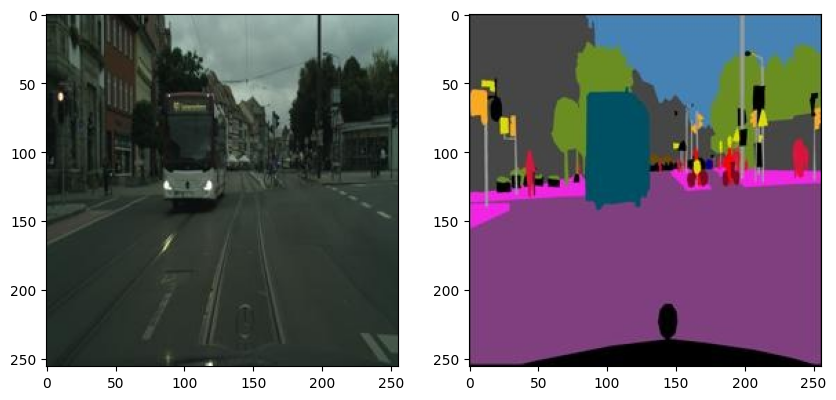

In [5]:
cityscape, label = split_image(sample_image)

print(cityscape.min(), cityscape.max(), label.min(), label.max())

cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## Define Labels

In [6]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 55  71 153]
 [106   8 232]
 [ 16 131 103]
 [255  32  32]
 [ 21 203 159]]


In [7]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [8]:
label_model.predict(color_array[:5, :])

array([8, 8, 9, 6, 4], dtype=int32)

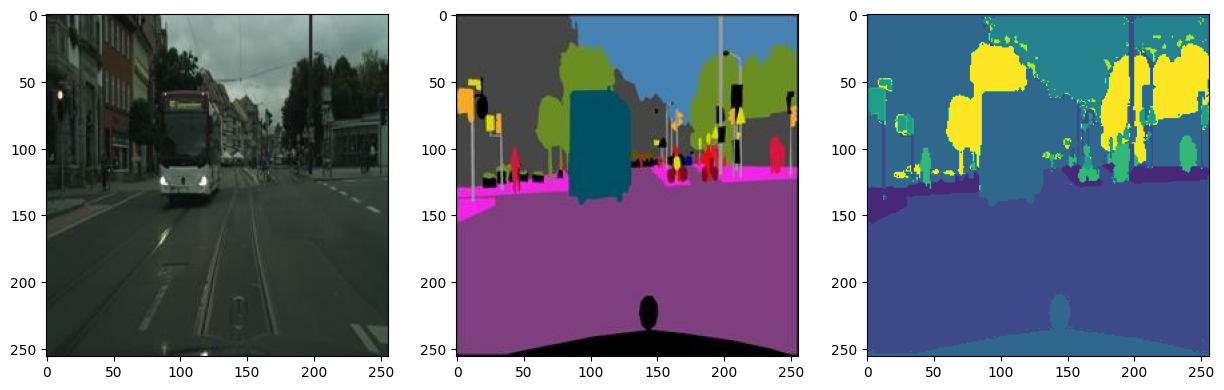

In [9]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [10]:
label_class

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 2, 2, 3],
       ...,
       [3, 3, 3, ..., 2, 2, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

## Dataset

In [11]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
dataset = CityscapeDataset(train_dir, label_model)
len(dataset)

2975

In [12]:
cityscape, label_class = dataset[0]
# print(cityscape.shape, label_class.shape)

## DataLoader

In [13]:
data_loader = DataLoader(
    dataset, batch_size=args.batch_size)

In [14]:
for X,y in data_loader:
    break

X.shape, y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

## The U-NET class
Let's see the code.

The example code get from https://amaarora.github.io/2020/09/13/model.html

<img src="./figures/u-net-architecture-2.png" title="UNET-2" />

In [15]:
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList(
            [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        # Max pooling layer
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x): 
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        # Up-convolution
        self.upconvs    = nn.ModuleList(
            [nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList(
            [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs
    
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_classes=1, retain_dim=True, out_sz=(256,256)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_classes, 1)#in_channels, out_channels, kernel_size
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz   

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:]) #1024, [512, 256, 128, 64]
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [16]:
model = UNet(num_classes = num_classes).to(device)
model

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

## 6. Train model

In [17]:
epochs = args.epochs 
lr = args.lr 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
step_losses = []
epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        
    epoch_loss_avg = epoch_loss / len(data_loader)
    epoch_losses.append(epoch_loss_avg)

    # Print the result for each epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss_avg:.4f}')

Epoch 1/10, Loss: 1.6120


Epoch 2/10, Loss: 1.2917


Epoch 3/10, Loss: 1.2008


Epoch 4/10, Loss: 1.1451


Epoch 5/10, Loss: 1.1189


Epoch 6/10, Loss: 1.0980


Epoch 7/10, Loss: 1.0708


Epoch 8/10, Loss: 1.0325


Epoch 9/10, Loss: 0.9787


Epoch 10/10, Loss: 0.9383


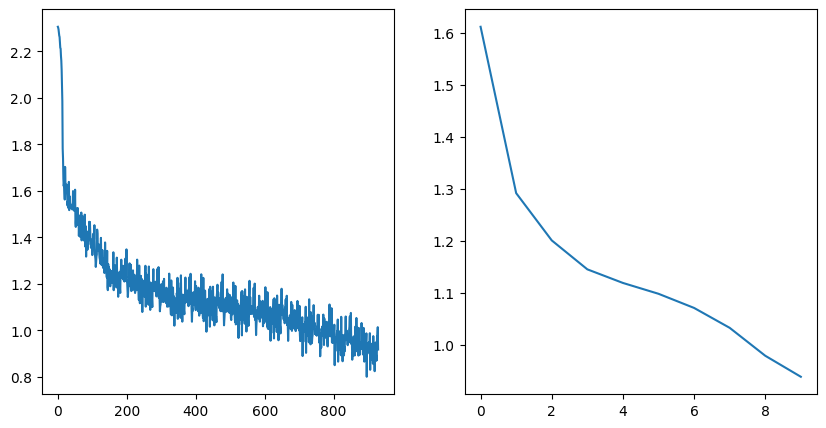

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [20]:
model_path = "./save_model/U-Net.pth"
torch.save(model.state_dict(), model_path)

## 7. Inference Check model predictions

In [22]:
model_path = "./save_model/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [24]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [25]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")